This Python code performs text classification using various machine learning models.

**Libraries and Modules**: The code first imports necessary libraries and modules including pandas for data manipulation, scikit-learn for machine learning tasks, matplotlib for plotting, and re for regular expressions.

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import re
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Loading and Preprocessing**: The function `load_and_preprocess_data` takes a file path as input and loads the dataset from a CSV file. It then preprocesses the data by dropping unnecessary columns, renaming columns, applying text preprocessing using regex, and creating a feature matrix (`X`) and a target vector (`y`). It also uses TfidfVectorizer for feature engineering and performs train-test split.

In [2]:
# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    try:
        # Load the dataset from a CSV file
        df = pd.read_csv(file_path, encoding='ISO-8859-1')

        # Data preprocessing
        df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)  # Dropping unnecessary columns
        df.rename(columns={"v1": "Label", "v2": "SMS"}, inplace=True)  # Renaming columns

        def preprocess_text(text):
            # Removing non-alphanumeric characters and converting to lowercase using regex
            return re.sub(r'[^a-zA-Z\s]', '', text.lower())

        # Apply preprocessing to the text data and create a new column
        df['processed_text'] = df['SMS'].apply(preprocess_text)

        # Define feature matrix (X) and target vector (y)
        X = df['processed_text']  # Processed SMS text
        y = df['Label']  # Spam or legitimate label

        # Feature engineering using TfidfVectorizer
        max_features = 10000
        tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=max_features)
        X_tfidf = tfidf_vectorizer.fit_transform(X)

        # Train-test split
        test_size = 0.2
        random_state = 42
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=test_size, random_state=random_state)

        return X_train, X_test, y_train, y_test, df, tfidf_vectorizer
    except FileNotFoundError:
        print("Error: File not found")
        return None, None, None, None, None, None

**Model Training**: The function `train_model` trains a given model using the training data. It converts the sparse matrix to a dense array before training the model.

In [3]:
# Function to train a model
def train_model(model, X_train, y_train):
    # Convert sparse matrix to dense array for training
    X_train_dense = X_train.toarray()

    # Train the model
    model.fit(X_train_dense, y_train)

**Model Evaluation**: The function `evaluate_model` evaluates a given model using the test data. It prints a classification report, confusion matrix, and if the model supports it, plots an ROC curve and calculates the area under the curve (AUC). It also performs cross-validation and calculates precision, recall, and F1-score.

In [4]:
# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    # Convert test data to dense array
    X_test_dense = X_test.toarray()

    if hasattr(model, 'predict'):
        predicted = model.predict(X_test_dense)

        # Print classification report and confusion matrix
        print('\n\n' + model_name + ' - Classification Report:\n', classification_report(y_test, predicted))
        conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
        print(model_name + ' - Confusion Matrix:\n', conf_mat)

        if hasattr(model, 'predict_proba'):
            # Convert text labels to numerical values: 'ham' -> 0, 'spam' -> 1
            y_test_numeric = y_test.map({'ham': 0, 'spam': 1})

            # Plot ROC curve and calculate AUC
            fpr, tpr, threshold = roc_curve(y_test_numeric, model.predict_proba(X_test_dense)[:,1])  # Use y_test_numeric
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=model_name + ' (AUC = %0.2f)' % roc_auc)
        else:
            print(model_name + " does not support predict_proba!")

        # Perform cross-validation and calculate precision, recall, and F1-score
        cv_scores = cross_val_score(model, X_train.toarray(), y_train, cv=5, scoring='accuracy')
        print("\nCross-Validation Scores for " + model_name + ":", cv_scores)

        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, predicted, average='binary',
                                                                      pos_label='spam')  # Set pos_label to 'spam'
        print("\nPrecision:", precision)
        print("Recall:", recall)
        print("F1-Score:", fscore)
    else:
        print(model_name + " does not support prediction!")

**Evaluating Multiple Models**: The function `evaluate_models` iterates through a dictionary of models, trains each model, evaluates it using the test data, and plots the ROC curve for comparison.

In [5]:
# Function to evaluate multiple models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    # Initialize a plot for ROC curve
    plt.figure(figsize=(10, 8))
    # Iterate through each model, train and evaluate it
    for model_name, model in models.items():
        train_model(model, X_train, y_train)
        evaluate_model(model, X_test, y_test, model_name)

    # Plot the ROC curve and display the graph
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

**Defining Models**: The code defines a dictionary of machine learning models including Logistic Regression, Random Forest, Naive Bayes, Decision Tree, and Support Vector Machine.

In [6]:
# Define models and evaluate them using the prepared data
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree (Gini)': DecisionTreeClassifier(criterion='gini', random_state=5),
    'Decision Tree (Entropy)': DecisionTreeClassifier(criterion='entropy', random_state=5),
    'Support Vector Machine': SVC(probability=True, random_state=5)
}

**Loading and Evaluating Data**: It then calls the `load_and_preprocess_data` function to load and preprocess the data. If successful, it proceeds to evaluate the models using the prepared data.



Logistic Regression - Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.71      0.83       150

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115

Logistic Regression - Confusion Matrix:
 [[965   0]
 [ 44 106]]

Cross-Validation Scores for Logistic Regression: [0.95515695 0.96188341 0.95398429 0.94163861 0.95735129]

Precision: 1.0
Recall: 0.7066666666666667
F1-Score: 0.828125


Random Forest - Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.81      0.89       150

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Random Forest - Confusi

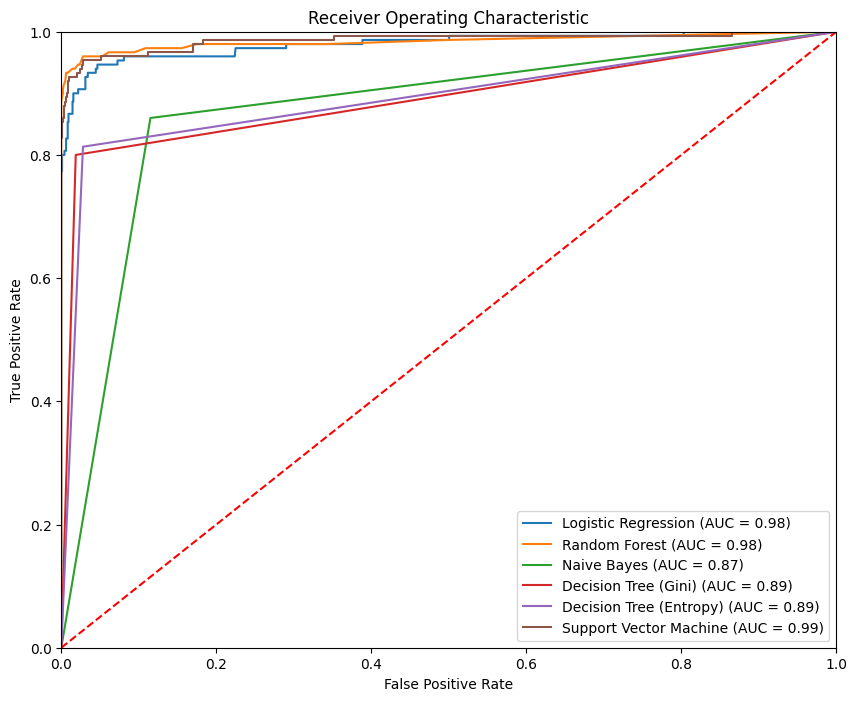

In [7]:
# Load and preprocess the data
X_train, X_test, y_train, y_test, df, tfidf_vectorizer = load_and_preprocess_data("/content/drive/MyDrive/Colab Notebooks/Neuronexus Innovations/Neuronexus Innovations - Machine Learning/Spam SMS Detection/spam.csv")

# If data is loaded successfully, evaluate the models
if X_train is not None:
    evaluate_models(models, X_train, X_test, y_train, y_test)

Each part of the code contributes to the overall process of loading, preprocessing, training, and evaluating machine learning models for text classification.

The script leverages pandas, scikit-learn, and matplotlib for data processing, model building, and visualization, respectively, to create and evaluate text classification models.